In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
!find "./dataset/train/speech/"  -name  '*.wav'  >speech_list.txt

In [4]:
!find "./dataset/train/noise/"  -name  '*.wav'  >noise_list.txt

In [5]:
import numpy as np
import scipy.io.wavfile as wav

from python_speech_features import sigproc, mfcc, delta

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from settings import *


def extract(sig):
    # framing
    sig_frames = sigproc.framesig(sig=sig, frame_len=FRAME_LENGTH, frame_step=FRAME_STEP)
    
    feat = []

    def calc_all_feat(feat_coeffs):
        feat.extend(feat_coeffs.max(axis=0))
        feat.extend(feat_coeffs.min(axis=0))
        feat.extend(feat_coeffs.mean(axis=0))
        feat.extend(feat_coeffs.var(axis=0))

    # region calculate mfcc features
    mfcc_feat = mfcc(signal=sig_frames, samplerate=SAMPLE_RATE, winlen=WINDOW_LENGTH, winstep=WINDOW_STEP,
                     numcep=13, preemph=PRE_EMPH, winfunc=WINDOW_FUNCTION)
    mfcc_feat_delta = delta(mfcc_feat, 20)
    mfcc_feat_delta_delta = delta(mfcc_feat_delta, 20)

    calc_all_feat(mfcc_feat)

    calc_all_feat(mfcc_feat_delta)

    calc_all_feat(mfcc_feat_delta_delta)

    return feat

def normalize_frames(m, Scale=True):
    if Scale:
        return (m - np.mean(m, axis=0))/(np.std(m, axis=0)+2e-12)
    else:
        return (m - np.mean(m, axis=0))

# 数据加载
class MyDataSet(Dataset):
    def __init__(self, filepath, transform=None):
        with open(filepath) as f:
            splited_line = f.read().splitlines()
        feas = []
        for line in splited_line:
            filepath = line.split()[0]
            feas.append((filepath))

        self.feas = feas

    def __getitem__(self, index):
        fn = self.feas[index]
        rate, sig = wav.read(fn)
        fea = extract(sig)
        fea = normalize_frames(np.array(fea))
        fea = torch.FloatTensor(fea)
        return fea

    def __len__(self):
        return len(self.feas)


# if __name__ == '__main__':
#     path = 'speech_list.txt'
#     batch_size = 5

#     train_dataset = MyDataSet(path)
#     print('train_dataset:', train_dataset)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     print(len(train_loader))
    
#     for batch_idx, batch_x in enumerate(train_loader):
#         batch_x = Variable(batch_x)
#         print('batch_x:', batch_x, batch_x.shape)

#         break

#     print('='*50)

In [6]:
class AE_DNN(nn.Module):
    def __init__(self, fea_dim=156, decode_dim=256):
        super(AE_DNN, self).__init__()
        self.fea_dim = fea_dim
        self.decode_dim =decode_dim
        self.en_layer1 = nn.Linear(self.fea_dim, 256)
        self.en_layer2 = nn.Linear(256, 256)
        self.en_layer3 = nn.Linear(256, 256)
        self.en_layer4 = nn.Linear(256, self.decode_dim)
        
        self.de_layer1 = nn.Linear(self.decode_dim, 256)
        self.de_layer2 = nn.Linear(256, 256)
        self.de_layer3 = nn.Linear(256, 256)
        self.de_layer4 = nn.Linear(256, self.fea_dim)

    def forward(self, x):
        out = F.relu(self.en_layer1(x))
        out = F.relu(self.en_layer2(out))
        out = F.relu(self.en_layer3(out))
        en_out = self.en_layer4(out)
        
        de_out = F.relu(self.de_layer1(en_out))
        de_out = F.relu(self.de_layer2(de_out))
        de_out = F.relu(self.de_layer3(de_out))
        de_out = self.de_layer4(de_out)
        
        return de_out

In [7]:
# input_data = torch.randn(1,156)#一个32x32的矩阵
# print(input_data.shape)
# model = AE_DNN()
# out = model(input_data)
# print(out)

# target = torch.randn(1, 156)#a dummy target,for example 
# target = target.view(1,-1)#make it the sanme shape as output 
# criterion = nn.MSELoss() 
# loss = criterion(out,target) 
# print(loss)

In [15]:
# -*- coding: utf-8 -*-

import os, sys
import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader


def process(Trainloader, Testloader, ae_model, criterion, optimizer, num_epochs):

    # -------------------------------- train -------------------------------------
    def train(train_loader, epoch):

        ae_model.train()  # train

        print_freq = 10

        pbar = tqdm(enumerate(train_loader))
        for batch_idx, datas in pbar:
            datas = Variable(datas)
            datas = datas.to(device)

            # Forward pass
            outputs = ae_model(datas)
            
            target = datas
            target = target.view(-1,156)
            
            loss = criterion(outputs, target)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch_idx + 1) % print_freq == 0:
                pbar.set_description(
                    'Train Epoch:{:3d}, Batch:[{:6d}/{:6d} ({:3.0f}%)], Loss: {:.6f}, '.format(
                        epoch, batch_idx + 1, len(train_loader), 100. * (batch_idx + 1) / len(train_loader),
                        loss.item()))

    # --------------------------------- test -------------------------------------
    def test(test_loader, epoch):

        ae_model.eval()  # eval
        
        tmp_scores = []
        
        with torch.no_grad():
            for batch_index, datas in tqdm(enumerate(test_loader)):
                datas = Variable(datas)
                datas,  = datas.to(device)

                outputs = ae_model(datas)
                
                loss = criterion(outputs, datas)
                
                score = loss.item()
                tmp_scores.append(score)

        return tmp_scores

    for epoch in tqdm(range(1, num_epochs+1)):

        train_score = train(Trainloader, epoch)

        test_scores = test(Testloader, epoch)

        torch.save(ae_model, 'OneClass_model_speech_noise_{}.pth'.format(epoch))

    return test_scores

In [16]:

train_dir = 'speech_list.txt'
dev_dir = 'noise_list.txt'

# ------------------------ Hyper parameters ----------------------------

num_epochs = 10
batch_size = 10
learning_rate = 0.001

# ------------------------- Data loader --------------------------------
train_dataset = MyDataSet(train_dir)
print('train_dataset:', train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

test_dataset = MyDataSet(train_dir)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         shuffle=False)

print('Train data size: {}'.format(len(train_loader.dataset)))
print('Test data size : {}'.format(len(test_loader.dataset)))

# ------------------------------- Load model ----------------------------
#     use_cuda = torch.cuda.is_available()
use_cuda = False

device = torch.device("cuda:0" if use_cuda else "cpu")

print('使用的设备是：', device)

ae_model = AE_DNN().to(device)
print(ae_model)

ae_para = sum([np.prod(list(p.size())) for p in ae_model.parameters()])
# # 下面的type_size是4，因为我们的参数是float32也就是4B，4个字节
print('\nModel {} : params: {:4f}M\n'.format(ae_model._get_name(), ae_para * 4 / 1024 / 1024))

train_dataset: <__main__.MyDataSet object at 0x7f788ecfcfd0>
Train data size: 357
Test data size : 357
使用的设备是： cpu
AE_DNN(
  (en_layer1): Linear(in_features=156, out_features=256, bias=True)
  (en_layer2): Linear(in_features=256, out_features=256, bias=True)
  (en_layer3): Linear(in_features=256, out_features=256, bias=True)
  (en_layer4): Linear(in_features=256, out_features=256, bias=True)
  (de_layer1): Linear(in_features=256, out_features=256, bias=True)
  (de_layer2): Linear(in_features=256, out_features=256, bias=True)
  (de_layer3): Linear(in_features=256, out_features=256, bias=True)
  (de_layer4): Linear(in_features=256, out_features=156, bias=True)
)

Model AE_DNN : params: 1.812119M



In [17]:
# ------------------------------ Loss and optimizer ---------------------
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss(reduce=False, size_average=False)
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(en_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)

In [18]:
test_score = process(train_loader, test_loader, ae_model, criterion, optimizer, num_epochs)


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:07,  7.89s/it]

2it [00:09,  5.90s/it]

3it [00:09,  4.20s/it]

4it [00:09,  3.10s/it]

5it [00:10,  2.29s/it]

6it [00:12,  2.23s/it]

7it [00:12,  1.72s/it]

9it [00:13,  1.34s/it]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 9it [00:13,  1.34s/it]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 11it [00:15,  1.17s/it]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 12it [00:16,  1.12s/it]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 13it [00:16,  1.11it/s]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 15it [00:17,  1.45it/s]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 16it [00:17,  1.58it/s]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 17it [00:18,  1.80it/s]

Train Epoch:  1, Batch:[    10/    36 ( 28%)], Loss: 0.489555, : : 18it [00:18,  1.84it/s]

Train Epoch:

 10%|█         | 1/10 [00:55<08:19, 55.46s/it]

0it [00:00, ?it/s]

1it [00:06,  6.94s/it]

2it [00:08,  5.35s/it]

3it [00:10,  4.19s/it]

4it [00:10,  3.13s/it]

5it [00:11,  2.52s/it]

6it [00:12,  1.95s/it]

7it [00:13,  1.56s/it]

9it [00:14,  1.31s/it]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 9it [00:14,  1.31s/it]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 10it [00:14,  1.04s/it]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 11it [00:15,  1.01it/s]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 12it [00:16,  1.10it/s]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 14it [00:17,  1.23it/s]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 15it [00:18,  1.35it/s]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 16it [00:19,  1.17it/s]

Train Epoch:  2, Batch:[    10/    36 ( 28%)], Loss: 0.044110, : : 17it [00:19,  1.47it/s]

Train

357it [00:37,  7.13it/s]


 20%|██        | 2/10 [01:53<07:29, 56.17s/it]

0it [00:00, ?it/s]

1it [00:06,  6.66s/it]

2it [00:09,  5.45s/it]

3it [00:10,  4.18s/it]

4it [00:11,  3.18s/it]

5it [00:11,  2.41s/it]

6it [00:12,  1.75s/it]

7it [00:12,  1.41s/it]

8it [00:12,  1.03s/it]

9it [00:13,  1.08it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 9it [00:14,  1.08it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 10it [00:14,  1.02s/it]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 11it [00:15,  1.08it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 12it [00:16,  1.22it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 13it [00:16,  1.23it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 14it [00:17,  1.38it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)], Loss: 0.041789, : : 15it [00:18,  1.45it/s]

Train Epoch:  3, Batch:[    10/    36 ( 28%)],

9it [00:14,  1.66s/it]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 9it [00:15,  1.66s/it]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 10it [00:15,  1.24s/it]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 12it [00:16,  1.08s/it]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 13it [00:17,  1.06it/s]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 14it [00:17,  1.28it/s]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 15it [00:18,  1.32it/s]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 16it [00:18,  1.41it/s]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 17it [00:19,  1.52it/s]

Train Epoch:  4, Batch:[    10/    36 ( 28%)], Loss: 0.041601, : : 18it [00:19,  1.83it/s]

Train Epoch:  4, Batch:[    20/    36 ( 56%)], Loss: 0.041870, : : 18it [00:19,  1.83it/s]

Train Epoch:  4, Batch:[    20/    36 ( 56%)], Loss: 0.04

Train Epoch:  5, Batch:[    10/    36 ( 28%)], Loss: 0.041473, : : 13it [00:15,  1.48it/s]

Train Epoch:  5, Batch:[    10/    36 ( 28%)], Loss: 0.041473, : : 14it [00:16,  1.26it/s]

Train Epoch:  5, Batch:[    10/    36 ( 28%)], Loss: 0.041473, : : 15it [00:17,  1.22it/s]

Train Epoch:  5, Batch:[    10/    36 ( 28%)], Loss: 0.041473, : : 16it [00:18,  1.37it/s]

Train Epoch:  5, Batch:[    10/    36 ( 28%)], Loss: 0.041473, : : 17it [00:18,  1.64it/s]

Train Epoch:  5, Batch:[    10/    36 ( 28%)], Loss: 0.041473, : : 18it [00:19,  1.55it/s]

Train Epoch:  5, Batch:[    20/    36 ( 56%)], Loss: 0.038621, : : 18it [00:19,  1.55it/s]

Train Epoch:  5, Batch:[    30/    36 ( 83%)], Loss: 0.055094, : : 18it [00:19,  1.55it/s]

Train Epoch:  5, Batch:[    30/    36 ( 83%)], Loss: 0.055094, : : 35it [00:19,  2.20it/s]

Train Epoch:  5, Batch:[    30/    36 ( 83%)], Loss: 0.055094, : : 36it [00:19,  1.87it/s]

0it [00:00, ?it/s]

2it [00:00, 12.48it/s]

3it [00:00, 10.38it/s]

5it [00:00, 

Train Epoch:  6, Batch:[    10/    36 ( 28%)], Loss: 0.036566, : : 19it [00:19,  2.19it/s]

Train Epoch:  6, Batch:[    20/    36 ( 56%)], Loss: 0.038896, : : 19it [00:19,  2.19it/s]

Train Epoch:  6, Batch:[    20/    36 ( 56%)], Loss: 0.038896, : : 27it [00:19,  3.09it/s]

Train Epoch:  6, Batch:[    30/    36 ( 83%)], Loss: 0.034792, : : 27it [00:19,  3.09it/s]

Train Epoch:  6, Batch:[    30/    36 ( 83%)], Loss: 0.034792, : : 36it [00:19,  1.80it/s]

0it [00:00, ?it/s]

2it [00:00, 11.89it/s]

3it [00:00, 10.14it/s]

5it [00:00, 10.02it/s]

6it [00:00,  7.98it/s]

7it [00:00,  6.96it/s]

9it [00:01,  8.09it/s]

10it [00:01,  8.21it/s]

12it [00:01,  8.62it/s]

14it [00:01,  8.16it/s]

16it [00:01,  8.85it/s]

17it [00:01,  8.26it/s]

19it [00:02,  9.06it/s]

21it [00:02,  9.46it/s]

23it [00:02,  9.54it/s]

25it [00:02, 10.40it/s]

27it [00:02, 11.31it/s]

29it [00:03, 10.84it/s]

31it [00:03, 10.92it/s]

33it [00:03, 10.00it/s]

35it [00:03, 10.17it/s]

37it [00:03, 10.73it/s]

3

Train Epoch:  7, Batch:[    30/    36 ( 83%)], Loss: 0.040577, : : 31it [00:20,  5.73it/s]

Train Epoch:  7, Batch:[    30/    36 ( 83%)], Loss: 0.040577, : : 36it [00:20,  1.78it/s]

0it [00:00, ?it/s]

2it [00:00, 12.29it/s]

3it [00:00,  9.99it/s]

4it [00:00,  9.66it/s]

5it [00:00,  9.41it/s]

7it [00:00,  8.32it/s]

9it [00:00,  9.29it/s]

10it [00:01,  9.02it/s]

12it [00:01,  9.27it/s]

14it [00:01,  9.50it/s]

16it [00:01,  9.53it/s]

17it [00:01,  8.65it/s]

19it [00:02,  9.32it/s]

21it [00:02,  9.59it/s]

23it [00:02,  9.58it/s]

25it [00:02, 10.35it/s]

27it [00:02, 11.16it/s]

29it [00:02, 10.63it/s]

31it [00:03, 10.67it/s]

33it [00:03,  9.82it/s]

35it [00:03, 10.05it/s]

37it [00:03, 10.60it/s]

39it [00:03, 10.84it/s]

41it [00:04, 10.21it/s]

43it [00:04, 10.20it/s]

45it [00:04, 10.60it/s]

47it [00:04, 10.00it/s]

49it [00:04, 10.58it/s]

51it [00:05,  9.96it/s]

53it [00:05,  9.97it/s]

55it [00:05, 10.02it/s]

57it [00:05, 10.95it/s]

59it [00:05, 10.97it/s]

61

0it [00:00, ?it/s]

2it [00:00, 12.49it/s]

3it [00:00, 10.44it/s]

4it [00:00, 10.22it/s]

5it [00:00,  9.74it/s]

6it [00:00,  9.79it/s]

7it [00:00,  8.85it/s]

8it [00:00,  8.81it/s]

10it [00:01,  9.21it/s]

12it [00:01,  9.40it/s]

13it [00:01,  9.46it/s]

14it [00:01,  9.12it/s]

16it [00:01,  9.20it/s]

17it [00:01,  8.40it/s]

19it [00:02,  9.11it/s]

21it [00:02,  9.40it/s]

23it [00:02,  9.46it/s]

25it [00:02, 10.19it/s]

27it [00:02, 11.05it/s]

29it [00:02, 10.61it/s]

31it [00:03, 10.70it/s]

33it [00:03,  9.81it/s]

35it [00:03, 10.05it/s]

37it [00:03, 10.60it/s]

39it [00:03, 10.85it/s]

41it [00:04, 10.24it/s]

43it [00:04, 10.21it/s]

45it [00:04, 10.60it/s]

47it [00:04,  9.99it/s]

49it [00:04, 10.50it/s]

51it [00:05,  9.87it/s]

53it [00:05,  9.90it/s]

55it [00:05,  9.99it/s]

57it [00:05, 10.92it/s]

59it [00:05, 10.93it/s]

61it [00:05, 11.16it/s]

63it [00:06, 10.94it/s]

65it [00:06, 11.98it/s]

67it [00:06, 11.31it/s]

69it [00:06, 11.86it/s]

71it [00:06,

19it [00:01,  9.71it/s]

21it [00:02,  9.96it/s]

23it [00:02,  9.90it/s]

25it [00:02, 10.74it/s]

27it [00:02, 11.62it/s]

29it [00:02, 11.07it/s]

31it [00:02, 11.10it/s]

33it [00:03, 10.12it/s]

35it [00:03, 10.38it/s]

37it [00:03, 10.94it/s]

39it [00:03, 11.18it/s]

41it [00:03, 10.46it/s]

43it [00:04, 10.47it/s]

45it [00:04, 10.91it/s]

47it [00:04, 10.28it/s]

49it [00:04, 10.85it/s]

51it [00:04, 10.24it/s]

53it [00:05, 10.27it/s]

55it [00:05, 10.31it/s]

57it [00:05, 11.26it/s]

59it [00:05, 11.32it/s]

61it [00:05, 11.62it/s]

63it [00:05, 11.40it/s]

65it [00:06, 12.50it/s]

67it [00:06, 11.77it/s]

69it [00:06, 12.38it/s]

71it [00:06, 11.90it/s]

73it [00:06, 11.70it/s]

75it [00:07, 10.22it/s]

77it [00:07,  9.85it/s]

79it [00:07, 10.54it/s]

81it [00:07, 11.20it/s]

83it [00:07, 11.02it/s]

85it [00:07, 11.04it/s]

87it [00:08, 10.72it/s]

89it [00:08, 10.14it/s]

91it [00:08, 10.13it/s]

93it [00:08, 10.34it/s]

95it [00:08, 10.09it/s]

97it [00:09, 10.57it/s]



39it [00:04, 10.52it/s]

41it [00:04,  9.92it/s]

43it [00:04,  9.98it/s]

45it [00:04, 10.39it/s]

47it [00:04,  9.83it/s]

49it [00:05, 10.42it/s]

51it [00:05,  9.84it/s]

53it [00:05,  9.85it/s]

54it [00:05,  9.69it/s]

56it [00:05, 10.24it/s]

58it [00:05, 10.89it/s]

60it [00:06, 10.76it/s]

62it [00:06, 10.84it/s]

64it [00:06, 11.33it/s]

66it [00:06, 11.37it/s]

68it [00:06, 11.77it/s]

70it [00:06, 11.06it/s]

72it [00:07, 10.61it/s]

74it [00:07, 10.31it/s]

76it [00:07,  9.02it/s]

77it [00:07,  8.88it/s]

78it [00:07,  8.96it/s]

80it [00:08, 10.17it/s]

82it [00:08,  9.89it/s]

84it [00:08, 10.33it/s]

86it [00:08, 10.19it/s]

88it [00:08,  9.70it/s]

90it [00:09,  9.73it/s]

92it [00:09,  9.02it/s]

94it [00:09,  9.61it/s]

95it [00:09,  9.68it/s]

97it [00:09, 10.28it/s]

99it [00:09, 11.25it/s]

101it [00:10, 11.50it/s]

103it [00:10, 11.23it/s]

105it [00:10, 11.21it/s]

107it [00:10, 11.06it/s]

109it [00:10, 11.18it/s]

111it [00:11, 10.92it/s]

113it [00:11,  9.77

In [19]:
import matplotlib.pyplot as plt

/home/zhudong/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


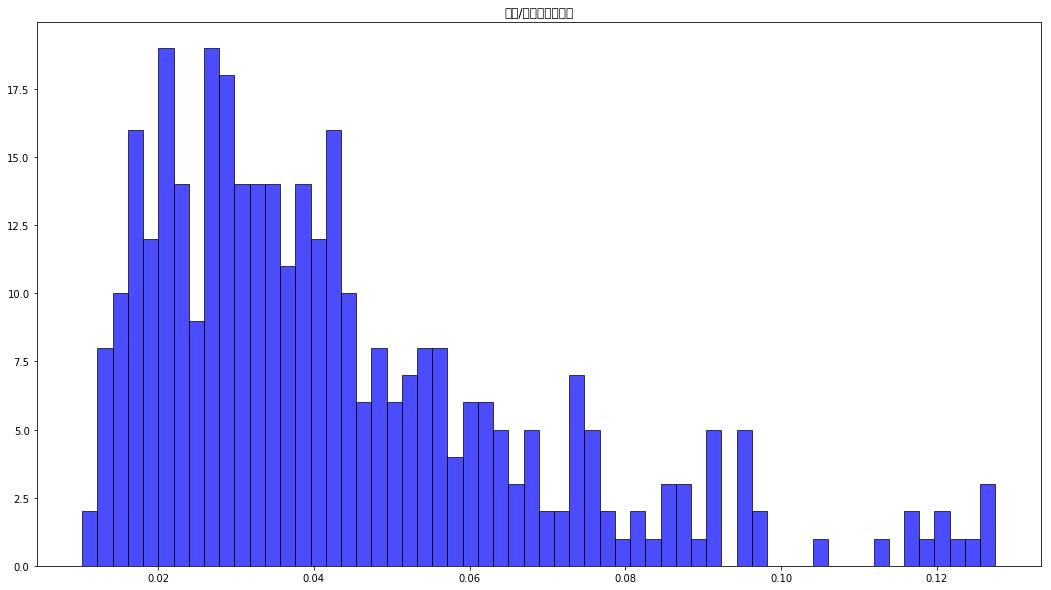

In [20]:
plt.figure(figsize=(18,10))
plt.hist(np.array(test_score), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.hist(np.array(test_scores)[itemindex_notis], bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [26]:
def test_process(Testloader, model, criterion):
    # --------------------------------- test -------------------------------------
    def test(test_loader):

        model.eval()  # eval
        
        tmp_scores = []
        
        with torch.no_grad():
            for batch_index, datas in tqdm(enumerate(test_loader)):
                datas = Variable(datas)
                datas = datas.to(device)

                outputs = model(datas)
                
                loss = criterion(outputs, datas)
                score = loss.item()
                tmp_scores.append(score)

        return tmp_scores

    test_scores = test(Testloader)
    
    return test_scores

In [23]:
dev_dir = 'noise_list.txt'

test_dataset = MyDataSet(dev_dir)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         shuffle=False)

print('Test data size : {}'.format(len(test_loader.dataset)))

# model_load = AE_DNN().to(device)
# model_load.(torch.load('OneClass_model_speech_noise_9.pth'))


model_load = torch.load('OneClass_model_speech_noise_9.pth')

model_load.eval()

Test data size : 334


AE_DNN(
  (en_layer1): Linear(in_features=156, out_features=256, bias=True)
  (en_layer2): Linear(in_features=256, out_features=256, bias=True)
  (en_layer3): Linear(in_features=256, out_features=256, bias=True)
  (en_layer4): Linear(in_features=256, out_features=256, bias=True)
  (de_layer1): Linear(in_features=256, out_features=256, bias=True)
  (de_layer2): Linear(in_features=256, out_features=256, bias=True)
  (de_layer3): Linear(in_features=256, out_features=256, bias=True)
  (de_layer4): Linear(in_features=256, out_features=156, bias=True)
)

In [27]:
noise_score = test_process(test_loader, model_load, criterion)


0it [00:00, ?it/s]
2it [00:00, 14.64it/s]
4it [00:00, 13.75it/s]
6it [00:00, 13.81it/s]
8it [00:00, 14.15it/s]
10it [00:00, 12.87it/s]
12it [00:00, 12.32it/s]
14it [00:01, 10.25it/s]
15it [00:01,  8.59it/s]
17it [00:01,  8.87it/s]
19it [00:01,  9.49it/s]
21it [00:02,  9.03it/s]
23it [00:02,  9.69it/s]
25it [00:02, 10.07it/s]
27it [00:02,  9.45it/s]
28it [00:02,  9.45it/s]
30it [00:02, 10.04it/s]
32it [00:03, 10.58it/s]
34it [00:03, 11.16it/s]
36it [00:03, 11.32it/s]
38it [00:03,  9.75it/s]
40it [00:03,  9.67it/s]
42it [00:04,  9.88it/s]
44it [00:04,  9.90it/s]
46it [00:04, 10.37it/s]
48it [00:04, 10.94it/s]
50it [00:04, 11.64it/s]
52it [00:04, 12.22it/s]
54it [00:05, 11.24it/s]
56it [00:05, 10.28it/s]
58it [00:05, 10.22it/s]
60it [00:05, 10.78it/s]
62it [00:05, 10.69it/s]
64it [00:06, 10.39it/s]
66it [00:06, 11.09it/s]
68it [00:06, 11.10it/s]
70it [00:06,  9.63it/s]
72it [00:06, 10.42it/s]
74it [00:07, 10.55it/s]
76it [00:07, 10.13it/s]
78it [00:07, 10.08it/s]
80it [00:07, 10.37it/s]


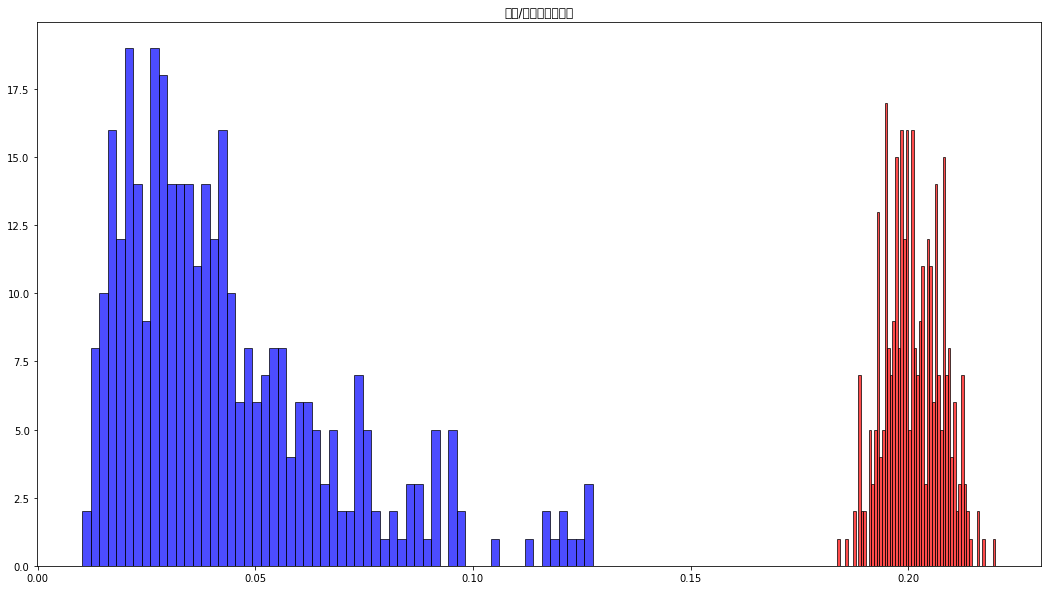

In [29]:
plt.figure(figsize=(18,10))
plt.hist(np.array(test_score), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(noise_score), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()